In [61]:
#Import required libraries

import numpy as np
import phate as ph
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score


In [62]:
#Load the dataset

import gzip
import numpy as np

def extract_and_read(filename):
    with gzip.open(filename, 'rb') as f:
        data = f.read()
    return data

def read_idx(data):
    # Read magic number
    magic = data[:4]
    # Read number of items
    num_items = int.from_bytes(data[4:8], byteorder='big')
    
    if magic == b'\x00\x00\x08\x03': # for images
        num_rows = int.from_bytes(data[8:12], byteorder='big')
        num_cols = int.from_bytes(data[12:16], byteorder='big')
        # Read data
        data = np.frombuffer(data[16:], dtype=np.uint8).reshape(num_items, num_rows, num_cols)
    elif magic == b'\x00\x00\x08\x01': # for labels
        # Read data
        data = np.frombuffer(data[8:], dtype=np.uint8)
    else:
        raise ValueError("Invalid magic number")
        
    return data

# Filenames of the zip files
filenames = {
    'train-images': 'Data/train-images-idx3-ubyte.gz',
    'train-labels': 'Data/train-labels-idx1-ubyte.gz',
    'test-images': 'Data/t10k-images-idx3-ubyte.gz',
    'test-labels': 'Data/t10k-labels-idx1-ubyte.gz'
}

# Read data
data = {}
for key, filename in filenames.items():
    with open(filename, 'rb') as f:
        data[key] = extract_and_read(filename)

# Parse and extract data
train_images = read_idx(data['train-images'])
train_labels = read_idx(data['train-labels'])
test_images = read_idx(data['test-images'])
test_labels = read_idx(data['test-labels'])

# Example usage
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)



Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [63]:
#Section A) Run rate on the train datasets without labels? 
train_images_reshape = train_images.reshape((train_images.shape[0],train_images.shape[1]*train_images.shape[2]))

n = 60000 #subset of points because phate takes a long time to run
train_features = train_images_reshape[:n,:]
train_labels_sub = train_labels[:n]

phate_operator = ph.PHATE(n_jobs=12) #allow it to run on twelve processes
phate_embedding = phate_operator.fit_transform(train_features)

embedding1 = phate_embedding

#Get t from VNE
t_vne = phate_operator.optimal_t

t_values = [t_vne-1,t_vne+1]

#get new imbedding
phate_operator.set_params(t=t_values[0])
embedding2 = phate_operator.fit_transform(train_features)

phate_operator.set_params(t=t_values[1])
embedding3 = phate_operator.fit_transform(train_features)

embedding_array = [embedding1,embedding2,embedding3]


Calculating PHATE...
  Running PHATE on 60000 observations and 784 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 148.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.65 seconds.
  Calculated graph and diffusion operator in 150.96 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 5.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.72 seconds.
  Calculated landmark operator in 9.04 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 1.16 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.39 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.45 seconds.
Calculated PHATE in 165.00 seconds.
Calculating PHATE...
  Running PHATE on 60000 observations and 784 variables.
  Calculating graph and diffus

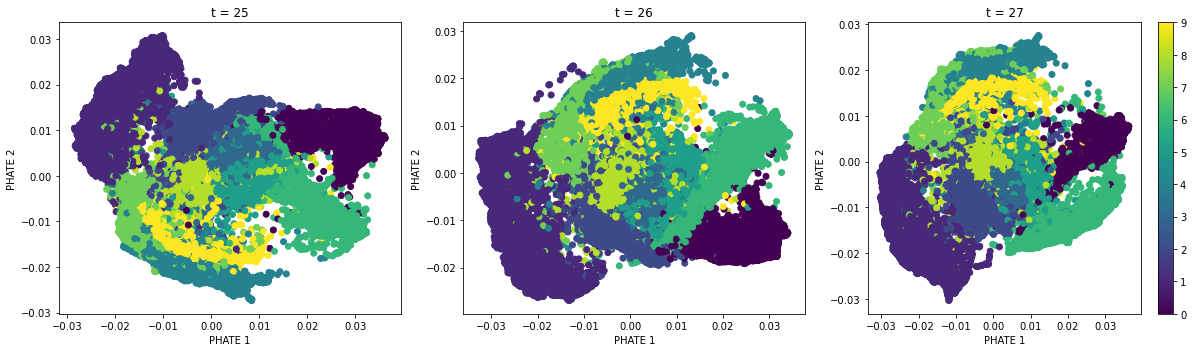

In [64]:
#Plotting the REsults of part A
t_list = [t_vne-1,t_vne,t_vne+1]

fig, axs = plt.subplots(1, len(embedding_array), figsize=(17, 5))

for i, embedding in enumerate(embedding_array):
    scatter = axs[i].scatter(embedding[:, 0], embedding[:, 1], c=train_labels_sub[:], cmap='viridis')
    axs[i].set_title(f"t = {t_list[i]}")
    axs[i].set_xlabel("PHATE 1")
    axs[i].set_ylabel("PHATE 2")
fig.colorbar(scatter,ax=axs[2],orientation='vertical')
plt.tight_layout()
plt.savefig('Figures/Problem4_partA.png',dpi=200)



Average ARI Value KNN: 0.36621045984045814
KNN seems to work pretty well for this, nothing too strange for this selection of the data


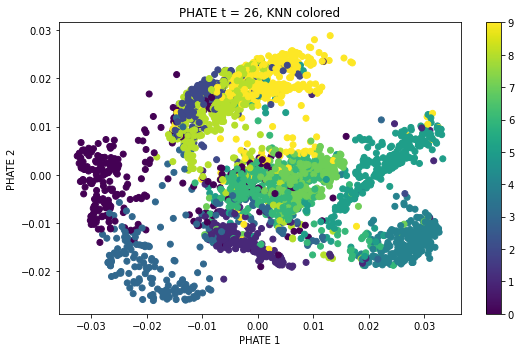

In [65]:
#Part B, Apply K-means clustering to features of the training data

np.random.seed(10) #set seed so we get the same results for each time it is trained
# Subsampling to make computation feasible
n_subsamples = 10
label_count = 10
ari_scores = []

for i in range(n_subsamples):
    subsample_indices = np.random.choice(len(train_features), size=3000, replace=False)
    subsample_features = train_features[subsample_indices]

    #k-means clustering
    kmeans = KMeans(n_clusters=label_count)
    cluster_labels = kmeans.fit_predict(subsample_features)

    # Compute Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(train_labels_sub[subsample_indices], cluster_labels)
    # Append to tracked list
    ari_scores.append(ari)

# Compute average ARI
average_ari = np.mean(ari_scores)

print(f'Average ARI Value KNN: {average_ari}')

#Visualize the clustering from Phate, and the 

embedding2_subset = embedding2[subsample_indices]

fig, ax = plt.subplots(figsize=(8, 5))

scatter = ax.scatter(embedding2_subset[:, 0], embedding2_subset[:, 1], c=cluster_labels, cmap='viridis')
ax.set_title(f"PHATE t = {t_list[1]}, KNN colored")
ax.set_xlabel("PHATE 1")
ax.set_ylabel("PHATE 2")
fig.colorbar(scatter,ax=ax,orientation='vertical')
plt.tight_layout()
plt.savefig('Figures/Problem4_partB.png',dpi=200)

print('KNN seems to work pretty well for this, nothing too strange for this selection of the data')

/home/eric/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/eric/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/eric/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/eric/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/eric/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/eric/.loc

Average ARI Value KNN: -1.7557896444601613e-05
Spectral clustering does not work well for the mnist dataset, tried multiple gamma values and can not get anything to work right



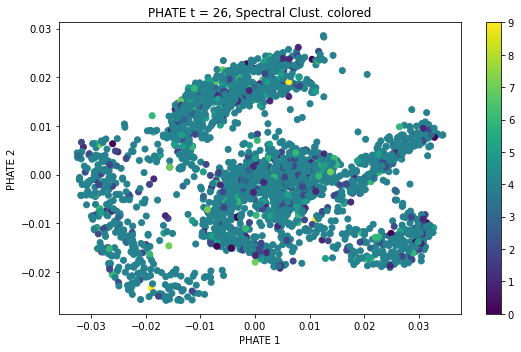

In [66]:
#Problem 4 Part C: apply spectral slustering to training data without labels, This method does not produce good results

# Subsampling to make computation feasible
n_subsamples = 10
ari_scores = []

for _ in range(n_subsamples):
    # Sample a subset of data
    # Assuming train_features is your 2D array of features without labels
    subsample_indices = np.random.choice(len(train_features), size=3000, replace=False)
    subsample_features = train_features[subsample_indices]

    # Apply spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=10, affinity='rbf', gamma=20)  # Adjust gamma as needed
    cluster_labels = spectral_clustering.fit_predict(subsample_features)

    # Compute Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(train_labels_sub[subsample_indices], cluster_labels)
    #append ARI score to the list of tracked ARI
    ari_scores.append(ari)

# Compute average ARI
average_ari = np.mean(ari_scores)

print(f'Average ARI Value KNN: {average_ari}')

#Visualize the clustering from Phate, and the color of spectral method

embedding2_subset = embedding2[subsample_indices]

fig, ax = plt.subplots(figsize=(8, 5))

scatter = ax.scatter(embedding2_subset[:, 0], embedding2_subset[:, 1], c=cluster_labels, cmap='viridis')
ax.set_title(f"PHATE t = {t_list[1]}, Spectral Clust. colored")
ax.set_xlabel("PHATE 1")
ax.set_ylabel("PHATE 2")
fig.colorbar(scatter,ax=ax,orientation='vertical')
plt.tight_layout()
plt.savefig('Figures/Problem4_partC.png',dpi=200)

print(f'Spectral clustering does not work well for the mnist dataset, tried multiple gamma values and can not get anything to work right\n')



In [67]:
#Problem 4 Part D

n = 60000 #subset of points because phate takes a long time to run
train_features = train_images_reshape[:n,:]
train_labels_sub = train_labels[:n]

phate_operator = ph.PHATE(n_components=10,n_jobs=12) #allow it to run on twelve processes and let it use only ten parameters
phate_embedding = phate_operator.fit_transform(train_features)

embedding_partd = phate_embedding

#Get t from VNE
t_vne_d = phate_operator.optimal_t

#report the t_value
print(f'Optimal t value VNE given 10 components: {t_vne_d}')


Calculating PHATE...
  Running PHATE on 60000 observations and 784 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.99 seconds.
    Calculating KNN search...
    Calculated KNN search in 148.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.55 seconds.
  Calculated graph and diffusion operator in 150.82 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 5.14 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.47 seconds.
  Calculated landmark operator in 8.78 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 1.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.33 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 54.75 seconds.
Calculated PHATE in 215.81 seconds.
Optimal t value VNE given 10 components: 26


Average ARI Value KNN: 0.6915951465720499
KNN on the reduced matrix works even better almost doubling the ARI value


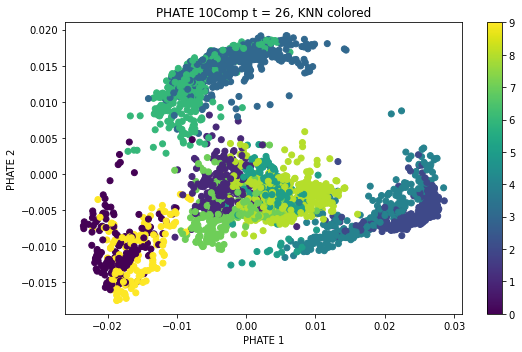

In [68]:

#apply phate to the 10 dimensional embedding
#print(embedding_partd.shape)


np.random.seed(10) #set seed so we get the same results for each time it is trained
# Subsampling to make computation feasible
n_subsamples = 10
label_count = 10
ari_scores = []

for i in range(n_subsamples):
    subsample_indices = np.random.choice(len(embedding_partd), size=3000, replace=False)
    subsample_features = embedding_partd[subsample_indices]

    #k-means clustering
    kmeans = KMeans(n_clusters=label_count)
    cluster_labels = kmeans.fit_predict(subsample_features)

    # Compute Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(train_labels_sub[subsample_indices], cluster_labels)
    # Append to tracked list
    ari_scores.append(ari)

# Compute average ARI
average_ari = np.mean(ari_scores)

print(f'Average ARI Value KNN: {average_ari}')

#Visualize the clustering from Phate, and the 

embedding_partd_sub = embedding_partd[subsample_indices]

fig, ax = plt.subplots(figsize=(8, 5))

scatter = ax.scatter(embedding_partd_sub[:, 0], embedding_partd_sub[:, 1], c=cluster_labels, cmap='viridis')
ax.set_title(f"PHATE 10Comp t = {t_list[1]}, KNN colored")
ax.set_xlabel("PHATE 1")
ax.set_ylabel("PHATE 2")
fig.colorbar(scatter,ax=ax,orientation='vertical')
plt.tight_layout()
plt.savefig('Figures/Problem4_partD.png',dpi=200)

print('KNN on the reduced matrix works even better almost doubling the ARI value')
